In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellek.dvc.experiment import load_experiments

experiments = load_experiments('prompt-engineering.json')
print(f"{len(experiments)} experiments")
experiments[0]

19 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'train'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'system_prompt': 'excellent-qa.txt',
   'user_prompt_template': 'icq-line.txt',
   'few_shot_examples': 'empty.json'},
  'run': 2},
 'metrics': {'exact_match': 0.586568361921958,
  'f1': 0.6939285759126523,
  'fuzzy_match': 0.6545290400240746,
  '2hops': {'exact_match': 0.6145659432387313,
   'f1': 0.7205072396670257,
   'fuzzy_match': 0.6814134668892599},
  '3hops': {'exact_match': 0.49988602689765216,
   'f1': 0.6124656855355362,
   'fuzzy_match': 0.5767038978801003},
  '4hops': {'exact_match': 0.5676595744680851,
   'f1': 0.6728926865097078,
   'fuzzy_match': 0.6161702127659574}}}

In [3]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])

param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop_duplicates(subset=param_cols, inplace=True)

df = df.sort_values(["params.qa.model", "params.qa.system_prompt", "params.qa.user_prompt_template", "params.run"])
df.reset_index(drop=True, inplace=True)
df

,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.run,metrics.exact_match,...,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
0,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,cq.txt,empty.json,1,0.596750,...,0.664510,0.625904,0.738742,0.691152,0.508320,0.625640,0.586961,0.570213,0.677984,0.628085
1,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,cq.txt,empty.json,2,0.597552,...,0.664460,0.626600,0.739149,0.690943,0.509004,0.626136,0.586050,0.572766,0.681946,0.633191
2,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,cq.txt,empty.json,3,0.597402,...,0.664209,0.626669,0.739341,0.691361,0.508548,0.626608,0.585594,0.571064,0.677054,0.625532
3,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-line.txt,empty.json,1,0.585716,...,0.653526,0.613662,0.720152,0.680161,0.499886,0.612510,0.576248,0.564255,0.670184,0.616170
4,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-line.txt,empty.json,2,0.586568,...,0.654529,0.614566,0.720507,0.681413,0.499886,0.612466,0.576704,0.567660,0.672893,0.616170
5,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-line.txt,empty.json,3,0.585465,...,0.653977,0.613870,0.720825,0.681205,0.498746,0.611544,0.575336,0.561702,0.668522,0.614468
6,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-sep.txt,empty.json,1,0.597001,...,0.664360,0.624583,0.734766,0.689830,0.511511,0.624421,0.589469,0.578723,0.681406,0.632340
7,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-sep.txt,empty.json,2,0.596750,...,0.664911,0.623887,0.734151,0.689830,0.511739,0.625315,0.591065,0.582128,0.684921,0.635745
8,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,excellent-qa.txt,icq-sep.txt,empty.json,3,0.596850,...,0.664711,0.624235,0.735089,0.690109,0.511511,0.624908,0.589697,0.580426,0.683002,0.634043
9,bdsaglam/musique,answerable,train,llama-3-70b-tgi,0.1,no-role.txt,cq.txt,empty.json,1,0.605126,...,0.681011,0.638982,0.756314,0.713898,0.507408,0.643198,0.589469,0.555745,0.686080,0.620426


In [4]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols[:1]
    ]
    .count()
    .reset_index()
)
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match


In [5]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols
    ]
    .mean()
    .reset_index()
)
df_avg[["params.qa.system_prompt", 'params.qa.user_prompt_template', *metric_cols]].sort_values('metrics.2hops.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
3,no-role.txt,cq.txt,0.605276,0.727439,0.681178,0.639028,0.756415,0.714014,0.507712,0.643287,0.589773,0.556596,0.687112,0.620709
5,no-role.txt,icq-sep.txt,0.598338,0.717052,0.672368,0.629313,0.743409,0.702282,0.507560,0.638526,0.587645,0.558298,0.687767,0.622695
0,excellent-qa.txt,cq.txt,0.597235,0.710684,0.664393,0.626391,0.739077,0.691152,0.508624,0.626128,0.586202,0.571348,0.678995,0.628936
2,excellent-qa.txt,icq-sep.txt,0.596867,0.707474,0.664660,0.624235,0.734669,0.689923,0.511587,0.624882,0.590077,0.580426,0.683110,0.634043
1,excellent-qa.txt,icq-line.txt,0.585916,0.693716,0.654011,0.614033,0.720495,0.680927,0.499506,0.612173,0.576096,0.564539,0.670533,0.615603
4,no-role.txt,icq-line.txt,0.573411,0.692139,0.648744,0.603459,0.717897,0.678492,0.485601,0.615223,0.564775,0.533617,0.664170,0.598298


In [6]:
df_target = df_avg.copy()

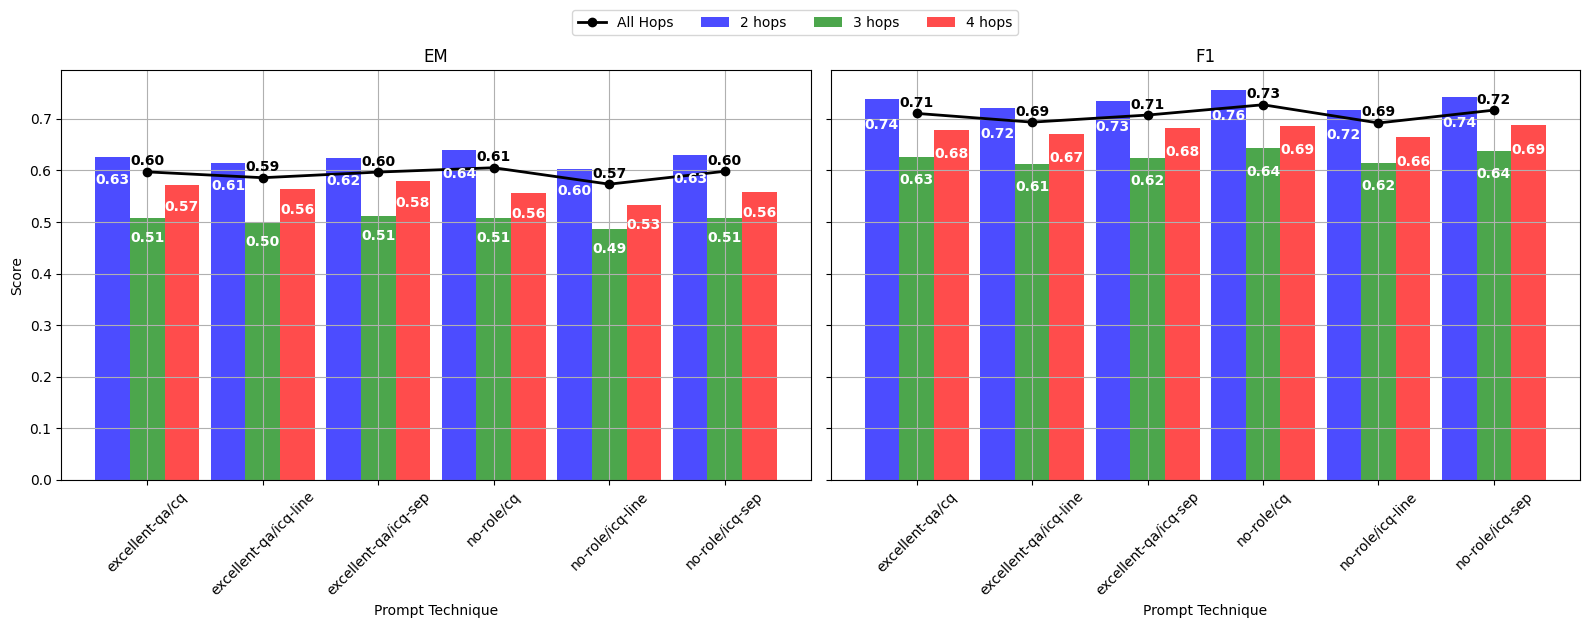

In [7]:
def plot_metric(ax, x, width, prompts, metrics, title, ylabel=None):
    bars_2hops = ax.bar(x - width, metrics["2hops"], width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + width, metrics["4hops"], width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=45)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


# Creating subplots for Exact Match and F1, separating them for clarity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

width = 0.3  # Bar width adjustment

# Changing the order of prompts to standard, cot-zs, cot-fs, cte
prompts = [f"{sp}/{up}" for sp, up in zip(df_target['params.qa.system_prompt'].values, df_target["params.qa.user_prompt_template"].values)]
x = np.arange(len(prompts))

# Plotting Exact Match
metrics_em = {
    "2hops": df_target["metrics.2hops.exact_match"].values,
    "3hops": df_target["metrics.3hops.exact_match"].values,
    "4hops": df_target["metrics.4hops.exact_match"].values,
    "all": df_target["metrics.exact_match"].values,
}
plot_metric(ax1, x, width, prompts, metrics_em, title="EM", ylabel="Score")

# Plotting F1
metrics_f1 = {
    "2hops": df_target["metrics.2hops.f1"].values,
    "3hops": df_target["metrics.3hops.f1"].values,
    "4hops": df_target["metrics.4hops.f1"].values,
    "all": df_target["metrics.f1"].values,
}
plot_metric(ax2, x, width, prompts, metrics_f1, title="F1")

# Creating a shared legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

plt.tight_layout()
plt.show()